# Homework

1. Compare the quality of your model when using different:
 - batch sizes,
 - learning rates,
 - activation functions.

If you have time, experiment with how to improve the model. Note: training and validation data can be used to compare models, but test data should be saved until the end as a final check of generalization.



In [1]:
%matplotlib inline

import torch
import torchvision
from torch import nn
import pandas as pd
import numpy
import matplotlib.pyplot as plt
import time

Loading data

In [2]:
training_data = torchvision.datasets.MNIST(
    root="data",
    train=True,
    download=True,
    transform=torchvision.transforms.ToTensor()
)

test_data = torchvision.datasets.MNIST(
    root="data",
    train=False,
    download=True,
    transform=torchvision.transforms.ToTensor()
)

Failed to download (trying next):
<urlopen error [SSL: CERTIFICATE_VERIFY_FAILED] certificate verify failed: certificate has expired (_ssl.c:1007)>



100%|██████████| 9.91M/9.91M [00:01<00:00, 8.95MB/s]


Extracting data/MNIST/raw/train-images-idx3-ubyte.gz to data/MNIST/raw

Failed to download (trying next):
<urlopen error [SSL: CERTIFICATE_VERIFY_FAILED] certificate verify failed: certificate has expired (_ssl.c:1007)>



100%|██████████| 28.9k/28.9k [00:00<00:00, 1.57MB/s]


Extracting data/MNIST/raw/train-labels-idx1-ubyte.gz to data/MNIST/raw

Failed to download (trying next):
<urlopen error [SSL: CERTIFICATE_VERIFY_FAILED] certificate verify failed: certificate has expired (_ssl.c:1007)>



100%|██████████| 1.65M/1.65M [00:00<00:00, 13.2MB/s]


Extracting data/MNIST/raw/t10k-images-idx3-ubyte.gz to data/MNIST/raw

Failed to download (trying next):
<urlopen error [SSL: CERTIFICATE_VERIFY_FAILED] certificate verify failed: certificate has expired (_ssl.c:1007)>



100%|██████████| 4.54k/4.54k [00:00<00:00, 8.25MB/s]

Extracting data/MNIST/raw/t10k-labels-idx1-ubyte.gz to data/MNIST/raw



Spliting training data in training and validation

In [3]:
train_size = int(0.8 * len(training_data))  # 80% for training
val_size = len(training_data) - train_size  # Remaining 20% for validation
training_data, validation_data = torch.utils.data.random_split(training_data, [train_size, val_size], generator=torch.Generator().manual_seed(55))

In [4]:
print('MNIST data loaded: train:',len(training_data),' examples, validation: ', len(validation_data), 'examples, test:',len(test_data), 'examples')
print('Input shape', training_data[0][0].shape)

MNIST data loaded: train: 48000  examples, validation:  12000 examples, test: 10000 examples
Input shape torch.Size([1, 28, 28])


Making data set iterable

In [5]:
batch_size = 128
# The dataloader makes our dataset iterable
train_dataloader = torch.utils.data.DataLoader(training_data, batch_size=batch_size)
val_dataloader = torch.utils.data.DataLoader(validation_data, batch_size=batch_size)

In [6]:
#create dataloader for test data
# The dataloader makes our dataset iterable
batch_size_test = 128
test_dataloader = torch.utils.data.DataLoader(test_data, batch_size=batch_size_test)

Functions to train and evaluate

In [7]:
def train_one_epoch(dataloader, model, loss_fn, optimizer):
    model.train()
    for batch, (X, y) in enumerate(dataloader):
        # forward pass
        pred = model(X)
        loss = loss_fn(pred, y)

        # backward pass calculates gradients
        loss.backward()

        # take one step with these gradients
        optimizer.step()

        # resets the gradients
        optimizer.zero_grad()

In [8]:
def evaluate(dataloader, model, loss_fn):
    # Set the model to evaluation mode - some NN pieces behave differently during training
    # Unnecessary in this situation but added for best practices
    model.eval()
    size = len(dataloader.dataset)
    num_batches = len(dataloader)
    loss, correct = 0, 0

    # We can save computation and memory by not calculating gradients here - we aren't optimizing
    with torch.no_grad():
        # loop over all of the batches
        for X, y in dataloader:
            pred = model(X)
            loss += loss_fn(pred, y).item()
            # how many are correct in this batch? Tracking for accuracy
            correct += (pred.argmax(1) == y).type(torch.float).sum().item()

    loss /= num_batches
    correct /= size

    accuracy = 100*correct
    return accuracy, loss

Training and evaluating base non linear classifier

In [9]:
class NonlinearClassifier(nn.Module):

    def __init__(self):
        super().__init__()
        self.flatten = nn.Flatten()
        self.layers_stack = nn.Sequential(
            nn.Linear(28*28, 50),
            nn.ReLU(),
            nn.Dropout(0.2),
            nn.Linear(50, 50),
            nn.ReLU(),
           # nn.Dropout(0.2),
            nn.Linear(50, 50),
            nn.ReLU(),
           # nn.Dropout(0.2),
            nn.Linear(50, 10)
        )

    def forward(self, x):
        x = self.flatten(x)
        x = self.layers_stack(x)

        return x

In [10]:
nonlinear_model = NonlinearClassifier()
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(nonlinear_model.parameters(), lr=0.05)

In [11]:
%%time

epochs = 5
train_acc_all = []
val_acc_all = []
for j in range(epochs):
    train_one_epoch(train_dataloader, nonlinear_model, loss_fn, optimizer)

    # checking on the training loss and accuracy once per epoch
    acc, loss = evaluate(train_dataloader, nonlinear_model, loss_fn)
    train_acc_all.append(acc)
    print(f"Epoch {j}: training loss: {loss}, accuracy: {acc}")

    # checking on the validation loss and accuracy once per epoch
    val_acc, val_loss = evaluate(val_dataloader, nonlinear_model, loss_fn)
    val_acc_all.append(val_acc)
    print(f"Epoch {j}: val. loss: {val_loss}, val. accuracy: {val_acc}")

Epoch 0: training loss: 0.7171015357971191, accuracy: 79.85208333333334
Epoch 0: val. loss: 0.7028929838474761, val. accuracy: 79.94166666666666
Epoch 1: training loss: 0.3726450708309809, accuracy: 89.3375
Epoch 1: val. loss: 0.3606990918200067, val. accuracy: 89.30833333333334
Epoch 2: training loss: 0.2865886700550715, accuracy: 91.72291666666666
Epoch 2: val. loss: 0.2795700665484083, val. accuracy: 91.71666666666667
Epoch 3: training loss: 0.23687786090373994, accuracy: 93.19375
Epoch 3: val. loss: 0.2319424884750488, val. accuracy: 92.975
Epoch 4: training loss: 0.2009329703648885, accuracy: 94.14583333333333
Epoch 4: val. loss: 0.19875605507416927, val. accuracy: 93.79166666666666
CPU times: user 1min 14s, sys: 171 ms, total: 1min 14s
Wall time: 1min 15s


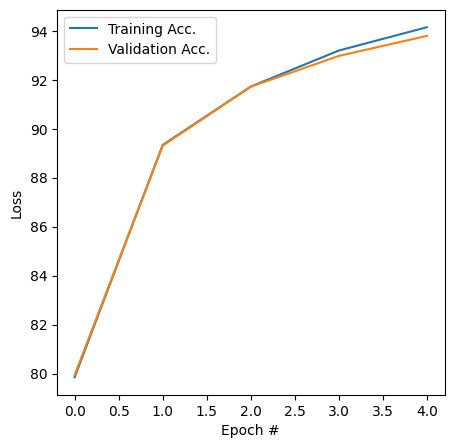

In [13]:
pltsize=1
plt.figure(figsize=(5*pltsize, 5*pltsize))
plt.plot(range(epochs), train_acc_all,label = 'Training Acc.' )
plt.plot(range(epochs), val_acc_all, label = 'Validation Acc.' )
plt.xlabel('Epoch #')
plt.ylabel('Loss')
plt.legend()

Evaluate the model on test data

In [14]:
acc_test, loss_test = evaluate(test_dataloader, nonlinear_model, loss_fn)
print("Test loss: %.4f, test accuracy: %.2f%%" % (loss_test, acc_test))

Test loss: 0.1969, test accuracy: 93.83%


Trying different batch sizes

In [21]:
%%time

batch_size = {32, 64} #, 128, 256, 512
epochs = 5
df = pd.DataFrame({'N': range(1,epochs +1)})

for k in batch_size:

  train_dataloader = torch.utils.data.DataLoader(training_data, batch_size= k)
  val_dataloader = torch.utils.data.DataLoader(validation_data, batch_size= k)

  nonlinear_model = NonlinearClassifier()
  loss_fn = nn.CrossEntropyLoss()
  optimizer = torch.optim.SGD(nonlinear_model.parameters(), lr=0.05)

  train_acc_all = []
  val_acc_all = []

  for j in range(epochs):

    train_one_epoch(train_dataloader, nonlinear_model, loss_fn, optimizer)

    # checking on the training loss and accuracy once per epoch
    acc, loss = evaluate(train_dataloader, nonlinear_model, loss_fn)
    train_acc_all.append(acc)
    print(f"Epoch {j}: training loss: {loss}, accuracy: {acc}")

    # checking on the validation loss and accuracy once per epoch
    val_acc, val_loss = evaluate(val_dataloader, nonlinear_model, loss_fn)
    val_acc_all.append(val_acc)
    print(f"Epoch {j}: val. loss: {val_loss}, val. accuracy: {val_acc}")

  df['train_acc_'+ str(k)] = train_acc_all
  df['val_acc_'+ str(k)] = val_acc_all


Epoch 0: training loss: 0.26025041670228044, accuracy: 92.41458333333334
Epoch 0: val. loss: 0.2542660197416941, val. accuracy: 92.18333333333332
Epoch 1: training loss: 0.16464796521887184, accuracy: 95.11666666666667
Epoch 1: val. loss: 0.16842219146341086, val. accuracy: 94.89166666666667
Epoch 2: training loss: 0.13748782921706637, accuracy: 95.83125
Epoch 2: val. loss: 0.148448993028452, val. accuracy: 95.45833333333333
Epoch 3: training loss: 0.11373381096310914, accuracy: 96.59583333333333
Epoch 3: val. loss: 0.13038289575154582, val. accuracy: 96.05833333333334
Epoch 4: training loss: 0.10545322386097784, accuracy: 96.82708333333333
Epoch 4: val. loss: 0.1273313662695388, val. accuracy: 96.19166666666666
Epoch 0: training loss: 0.4265285677313805, accuracy: 87.42083333333333
Epoch 0: val. loss: 0.4170499345723619, val. accuracy: 87.34166666666667
Epoch 1: training loss: 0.2522674640317758, accuracy: 92.65833333333333
Epoch 1: val. loss: 0.2474593370360263, val. accuracy: 92.625

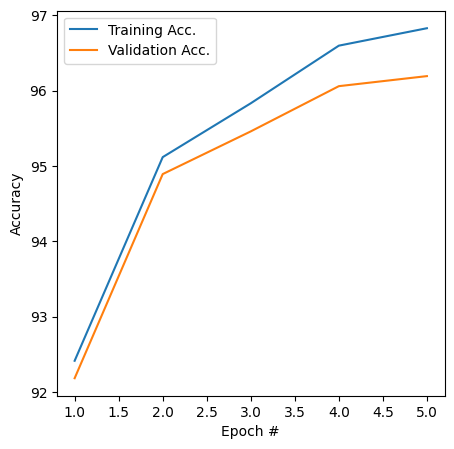

In [23]:
pltsize=1
plt.figure(figsize=(5*pltsize, 5*pltsize))
plt.plot(df['N'], df['train_acc_32'],label = 'Training Acc.' )
plt.plot(df['N'], df['val_acc_32'], label = 'Validation Acc.' )
plt.xlabel('Epoch #')
plt.ylabel('Accuracy')
plt.legend()

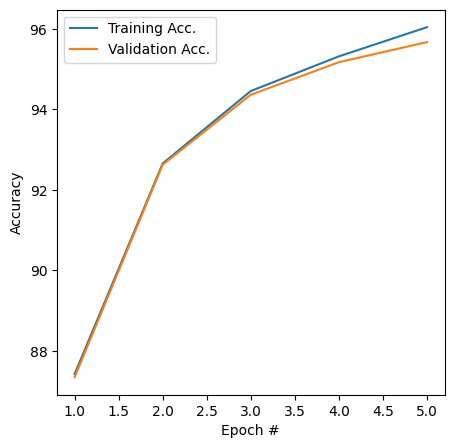

In [24]:
pltsize=1
plt.figure(figsize=(5*pltsize, 5*pltsize))
plt.plot(df['N'], df['train_acc_64'],label = 'Training Acc.' )
plt.plot(df['N'], df['val_acc_64'], label = 'Validation Acc.' )
plt.xlabel('Epoch #')
plt.ylabel('Accuracy')
plt.legend()

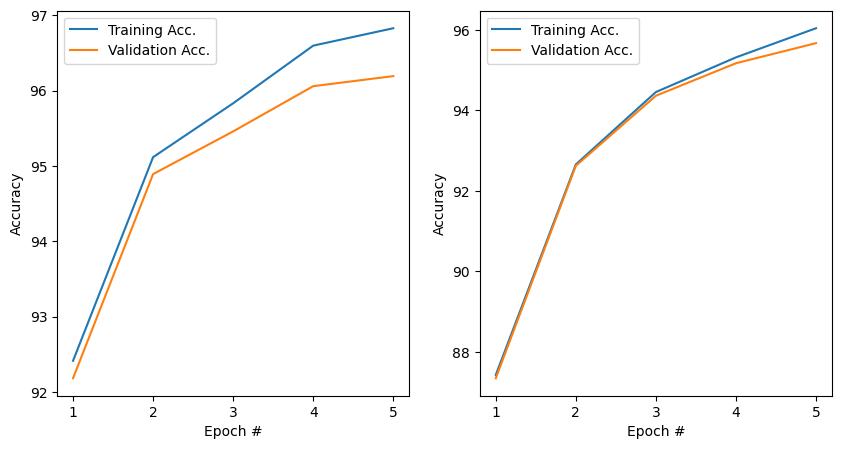

In [25]:
pltsize = 1
fig, axes = plt.subplots(1, 2, figsize=(10 * pltsize, 5 * pltsize))  # 1 row, 2 columns

# Plot 1
axes[0].plot(df['N'], df['train_acc_32'], label='Training Acc.')
axes[0].plot(df['N'], df['val_acc_32'], label='Validation Acc.')
axes[0].set_xlabel('Epoch #')
axes[0].set_ylabel('Accuracy')
axes[0].legend()

# Plot 2
axes[1].plot(df['N'], df['train_acc_64'], label='Training Acc.')
axes[1].plot(df['N'], df['val_acc_64'], label='Validation Acc.')
axes[1].set_xlabel('Epoch #')
axes[1].set_ylabel('Accuracy')
axes[1].legend()

plt.show()  # Display the figure with both subplots

2. Bonus: What is a learning rate scheduler?